In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/graduate-admissions/Admission_Predict.csv
/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv


# The infamous brain drain 

Over the past multiple decades, India has continually experienced human capital migration out of the country - with the most popular destination being the Middle East, the United States, the United Kingdom, Canada and Asia Pac among other regions/countries [1]. The figure below, from Pew Research, shows the emigration numbers for India as of 2017. Even though the emigration rate for India is low at about 1%, the number of migrants has more than doubled over the past 25 years, growing twice as fast as the world’s total migrant population.

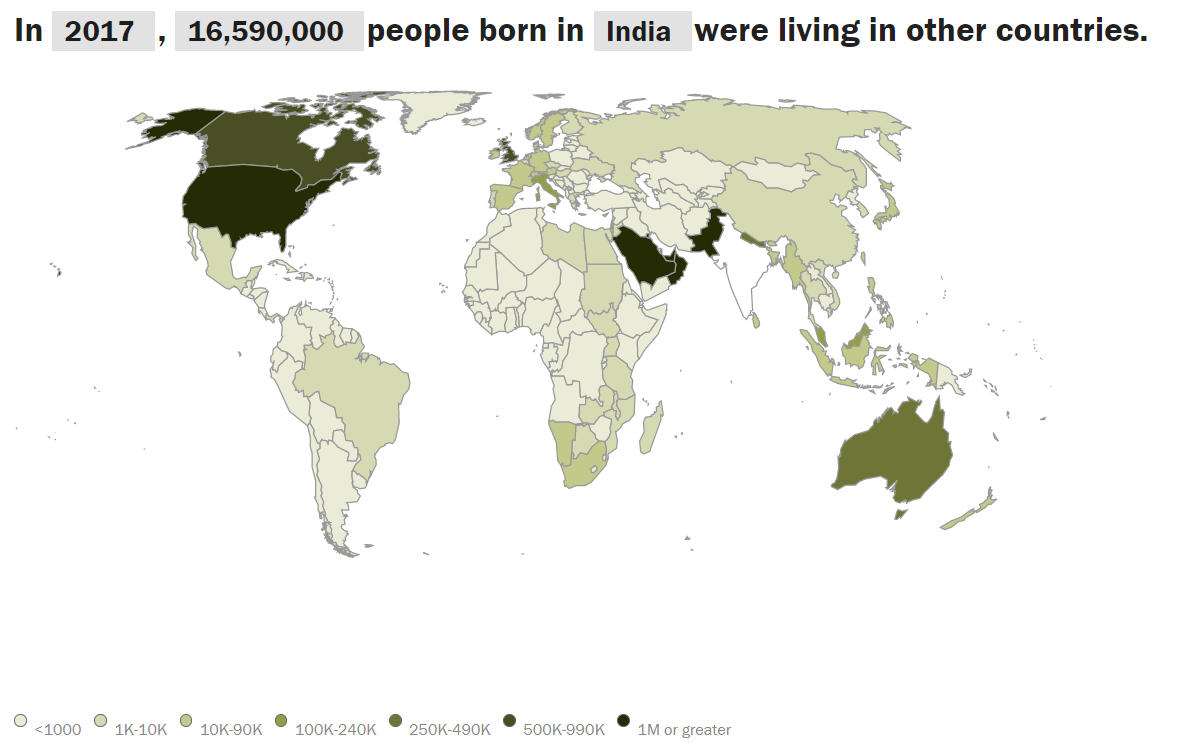

While the Middle East is a popular destination country for the working class, the West is a magnet for those pursuing higher education as a means to better opportunities outside of home. Among those coming to the US for higher education, the most popular fields of study happen to be engineering, math & computational sciences and social sciences. The recent digital boom in India did see a reversal in the emigration trends - but the trends seem to be reversing back.

This analysis is hoping to identify trends between admission to a Master's level graduate program in the US given various admission metrics.

**Reference:**
1. https://www.pewresearch.org/global/interactives/global-migrant-stocks-map/

# About the data set

**Reference:** 
Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019

The dataset contains several parameters which are considered important during the application for Masters Programs.
The parameters included are :

* GRE Scores ( out of 340 )
* TOEFL Scores ( out of 120 )
* University Rating ( out of 5 )
* Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
* Undergraduate GPA ( out of 10 )
* Research Experience ( either 0 or 1 )
* Chance of Admit ( ranging from 0 to 1 )

# Knowing the data

In [2]:
import numpy as np
import pandas as pd

import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

**Read in the data sets**

In [3]:
dat1 = pd.read_csv('../input/graduate-admissions/Admission_Predict.csv')
print('First Data Set ---------------------------------------------------')
print(dat1.describe())
print(dat1.info())

dat2 = pd.read_csv('../input/graduate-admissions/Admission_Predict_Ver1.1.csv')
print('\nSecond Data Set ------------------------------------------------')
print(dat2.describe())
print(dat2.info())

First Data Set ---------------------------------------------------
       Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  400.000000  400.000000   400.000000         400.000000  400.000000   
mean   200.500000  316.807500   107.410000           3.087500    3.400000   
std    115.614301   11.473646     6.069514           1.143728    1.006869   
min      1.000000  290.000000    92.000000           1.000000    1.000000   
25%    100.750000  308.000000   103.000000           2.000000    2.500000   
50%    200.500000  317.000000   107.000000           3.000000    3.500000   
75%    300.250000  325.000000   112.000000           4.000000    4.000000   
max    400.000000  340.000000   120.000000           5.000000    5.000000   

             LOR         CGPA    Research  Chance of Admit   
count  400.000000  400.000000  400.000000        400.000000  
mean     3.452500    8.598925    0.547500          0.724350  
std      0.898478    0.596317    0.498362          0.

In [4]:
dat = pd.concat([dat1, dat2], ignore_index=True)
print('Combining the two data sets without knowledge of duplication')
print(dat.describe())

df = dat.drop_duplicates()
print('\nDropping duplicates across the data sets')
print(df.describe())

df = df.set_index('Serial No.')
df.head()

Combining the two data sets without knowledge of duplication
       Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  900.000000  900.000000   900.000000         900.000000  900.000000   
mean   228.277778  316.621111   107.288889           3.102222    3.385556   
std    134.674991   11.369700     6.073968           1.143048    0.997612   
min      1.000000  290.000000    92.000000           1.000000    1.000000   
25%    113.000000  308.000000   103.000000           2.000000    2.500000   
50%    225.500000  317.000000   107.000000           3.000000    3.500000   
75%    338.000000  325.000000   112.000000           4.000000    4.000000   
max    500.000000  340.000000   120.000000           5.000000    5.000000   

            LOR         CGPA    Research  Chance of Admit   
count  900.00000  900.000000  900.000000        900.000000  
mean     3.47000    8.586433    0.554444          0.722900  
std      0.91319    0.600822    0.497303          0.141722  
m

GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
Serial No.                                                               
1                 337          118                  4  4.5   4.5  9.65   
2                 324          107                  4  4.0   4.5  8.87   
3                 316          104                  3  3.0   3.5  8.00   
4                 322          110                  3  3.5   2.5  8.67   
5                 314          103                  2  2.0   3.0  8.21   

            Research  Chance of Admit   
Serial No.                              
1                  1              0.92  
2                  1              0.76  
3                  1              0.72  
4                  1              0.80  
5                  0              0.65

**Profiling the data**

In [5]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Preprocessing**

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [7]:
np.random.seed(0)
# df = df.reindex(np.random.permutation(df.index))

col = df.columns
print(col)
y = df['Chance of Admit ']
X = df.drop(['Chance of Admit '], axis=1)

print(X.info())

X.describe()

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 31.2 KB
None


GRE Score  TOEFL Score  University Rating         SOP       LOR   \
count  500.000000   500.000000         500.000000  500.000000  500.00000   
mean   316.472000   107.192000           3.114000    3.374000    3.48400   
std     11.295148     6.081868           1.143512    0.991004    0.92545   
min    290.000000    92.000000           1.000000    1.000000    1.00000   
25%    308.000000   103.000000           2.000000    2.500000    3.00000   
50%    317.000000   107.000000           3.000000    3.500000    3.50000   
75%    325.000000   112.000000           4.000000    4.000000    4.00000   
max    340.000000   120.000000           5.000000    5.000000    5.00000   

             CGPA    Research  
count  500.000000  500.000000  
mean     8.576440    0.560000  
std      0.604813    0.496884  
min      6.800000    0.000000  
25%      8.127500    0.000000  
50%      8.560000    1.000000  
75%      9.040000    1.000000  
max      9.920000    1.000000

**Scaling train and test data**

<AxesSubplot:xlabel='Chance of Admit ', ylabel='Density'>

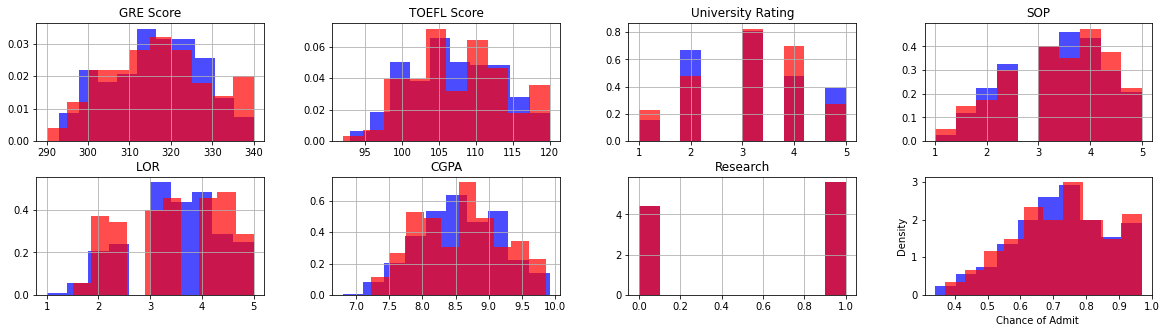

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2)
# check distributions across X_train and X_test
lcol = X_train.columns
ncol = len(lcol)
nbins = 10

fig, axs = plt.subplots(2,4,figsize=(20,5))
for i,col in enumerate(lcol):
    r,c = divmod(i,4)
    X_train.hist(density=1,column=col, bins=nbins, ax=axs[r,c],color = 'blue',alpha=0.7)
    X_test.hist(density=1, column=col, bins=nbins, ax=axs[r,c], color = 'red', alpha=0.7)

sns.histplot(y_train, bins=nbins, ax=axs[1,3], color= 'blue', alpha=0.7,linewidth=0, stat='density')
sns.histplot(y_test, bins=nbins, ax=axs[1,3], color= 'red', alpha=0.7,linewidth=0, stat='density')

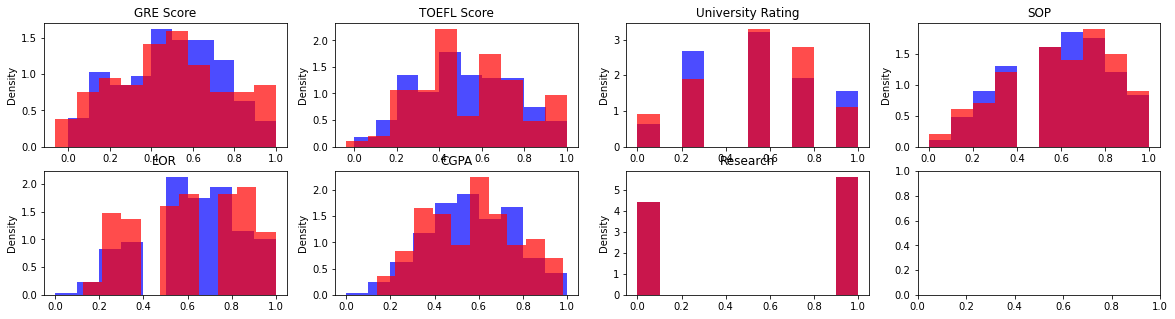

In [9]:
# Scaling the data
# sc = StandardScaler()
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

fig, axs = plt.subplots(2,4,figsize=(20,5))
for i in range(X_train_sc.shape[1]):
    r,c = divmod(i,4)    
    sns.histplot(X_train_sc[:,i], bins=nbins, ax=axs[r,c], color= 'blue', alpha=0.7,linewidth=0, stat='density').set_title(lcol[i])
    sns.histplot(X_test_sc[:,i], bins=nbins, ax=axs[r,c], color= 'red', alpha=0.7,linewidth=0, stat='density')

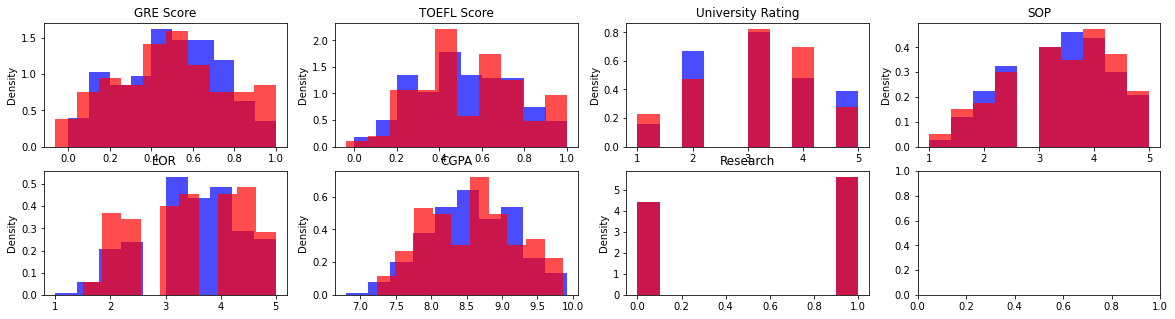

In [10]:
# Scale only part of the feature set
# features_to_scale = lcol # should replicate above cell
features_to_scale = ['GRE Score', 'TOEFL Score']
ct = ColumnTransformer([('Scale',MinMaxScaler(),features_to_scale)],remainder='passthrough')
X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

fig, axs = plt.subplots(2,4,figsize=(20,5))
for i in range(X_train_sc.shape[1]):
    r,c = divmod(i,4)    
    sns.histplot(X_train_ct[:,i], bins=nbins, ax=axs[r,c], color= 'blue', alpha=0.7,linewidth=0, stat='density').set_title(lcol[i])
    sns.histplot(X_test_ct[:,i], bins=nbins, ax=axs[r,c], color= 'red', alpha=0.7,linewidth=0, stat='density')

**Build functions**

In [11]:
def get_cv_score(model, X, y):
    scores = -1*cross_val_score(model,X,y,cv=5,scoring='neg_mean_absolute_error')
    return scores.mean()

In [12]:
def get_summary(model):
    sc = {}
    sc['Unscaled'] = get_cv_score(model, X_train, y_train)
    sc['Scaled'] = get_cv_score(model, X_train_sc, y_train)
    sc['PartScaled'] = get_cv_score(model, X_train_ct, y_train)

    model.fit(X_train_ct,y_train)
    y_predict = model.predict(X_test_ct)
    sc['RMSE'] = mean_squared_error(y_test,y_predict,squared=False)
    sc['R2'] = r2_score(y_test,y_predict)
        
    return sc, y_predict

In [13]:
pd.set_option('precision',1)
zz, ylr = get_summary(LinearRegression())
dd = pd.DataFrame({'LinearRegression':zz.values()}, index = zz.keys())

zz, yrf = get_summary(RandomForestRegressor())
dd['RandomForest'] = zz.values()
zz, ysvr = get_summary(SVR(kernel='linear'))
dd['SupportVector'] = zz.values()

pp = Pipeline([('poly',PolynomialFeatures(degree=2)),('lr',LinearRegression(fit_intercept=False))])
zz, ypp = get_summary(pp)
dd['2ndPoly'] = zz.values()

print(dd)

            LinearRegression  RandomForest  SupportVector  2ndPoly
Unscaled             4.2e-02       4.6e-02        5.1e-02  4.2e-02
Scaled               4.2e-02       4.6e-02        5.2e-02  4.2e-02
PartScaled           4.2e-02       4.6e-02        5.1e-02  4.2e-02
RMSE                 6.7e-02       7.0e-02        7.0e-02  6.7e-02
R2                   7.9e-01       7.7e-01        7.7e-01  7.9e-01


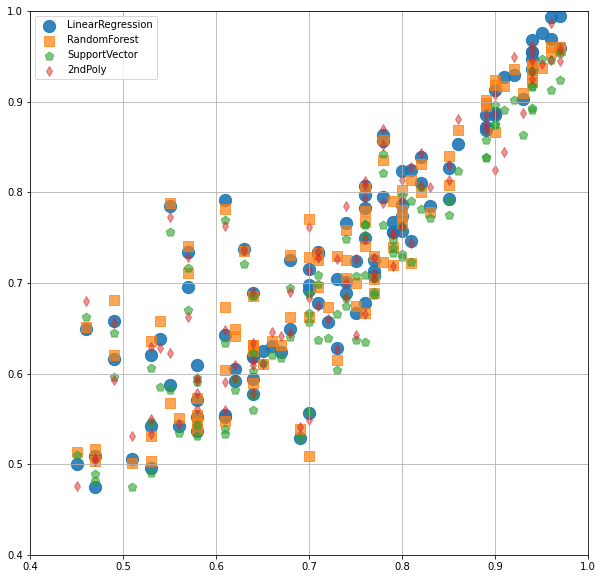

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,ylr,alpha=0.9,marker='o',s=150)
plt.scatter(y_test,yrf,alpha=0.7,marker='s',s=120)
plt.scatter(y_test,ysvr,alpha=0.6,marker='p',s=80)
plt.scatter(y_test,ypp,alpha=0.5,marker='d',s=50)
plt.legend(dd.keys())
plt.xlim([0.4,1])
plt.ylim([0.4,1])
plt.grid()
plt.show()

In [15]:
print('RMSE from linear regression for last 100 rows is:\n')
print(dd.loc['RMSE','LinearRegression'])

RMSE from linear regression for last 100 rows is:

0.06655287746564809
